In [1]:
#this script is used to create animation of the dfs

In [2]:
import pickle
import geopandas
import pandas as pd
pd.set_option('max_colwidth', 200)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns 
sns.set()
import os
from os import listdir
from os.path import isfile, join
import descartes
import csv
import numpy as np
%matplotlib inline
from random import sample
from math import sin, cos, sqrt, atan2, radians, acos
import numpy as np
import math
import copy
import time




In [3]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [4]:
g=load_obj('graph_final')


In [5]:

def get_stop(node):
    return int(node.split("_")[0])
    
def get_seconds(node):
    return int(node.split("_")[1])
    
# depth-first search through bus system
#
# graph: dict, key=node name, val=edge list
# node: node name
# max_time: last time (in seconds) beyond which we don't search (None if no limit)
# visited: set of nodes visited already (to avoid repeats)
def dfs(graph, node, max_time=None, visited=None, parent_node= None):
    if visited == None:
        visited = set()
    node_time = get_seconds(node)
    if max_time != None and node_time > max_time:
        return visited

    if node in visited:
        return visited
    
    if parent_node:
        trip_id = parent_node['trip_id'] 
    else: 
        trip_id = None
        
    visited.add(node)
    for edge in graph[node]:
            if not trip_id:
                dfs(graph, edge["destination"], max_time, visited, edge)
            else:
                if 'DROP OFF' in edge['full_bus_name']:
                    if edge['trip_id'] == trip_id:
                        dfs(graph, edge["destination"], max_time, visited, edge)

                    else: 
                        continue 
                else:
                    dfs(graph, edge["destination"], max_time, visited, edge)
    return visited

def stops_reachable_percent(start, hours=None):
    limit = None
    if hours != None:
        limit = get_seconds(start) + hours * 3600 # hours to seconds
    reachable = dfs(g, start, limit)
    reachable_stops = {get_stop(node) for node in reachable}
    all_stops = {get_stop(node) for node in g.keys()}
    hour_cover = (len(reachable_stops) / len(all_stops))
    return hour_cover, reachable   

# # where can we get if we start at this place/time, and have no time limit?
# print(stops_reachable_percent('1561_25223'))

# # one hour limit?
# print(stops_reachable_percent('1379_25260', 1))

# # two hour limit?
# print(stops_reachable_percent('1561_25223', 2))


In [6]:
f=load_obj('dfs_output_final')
h=load_obj('hour_coverage_final')

In [7]:
f=f['1787_26047']

In [8]:
list_of_stops = []
for s in f:
    sls =s.split('_', 1)[0] 
    if sls not in list_of_stops:
        list_of_stops.append(sls)
            

In [10]:
lakes = geopandas.read_file("Lakes_and_Rivers")
madison = geopandas.read_file("City_Limit")


#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161
weekday_bus = geopandas.read_file("Metro_Transit_Ridership_by_Route_Weekday")

#metro data
metro_data = geopandas.read_file("MetroBusRoutes.gdb")
list_metro = []
for index, row in metro_data.iterrows():
    list_metro.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

metro_series = pd.Series(list_metro)
metro_coord = pd.DataFrame({"Coordinates": metro_series})
metro_coord = geopandas.GeoDataFrame(metro_coord, geometry='Coordinates')

#BRT data 
#https://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-stops
# using new data for brt from the madison data instead of the BRT.gdb
brt_data = geopandas.read_file("Bus_Rapid_Transit_Stops")
list_brt = []
for index, row in brt_data.iterrows():
    list_brt.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

brt_series = pd.Series(list_brt)
brt_coord = pd.DataFrame({"Coordinates": brt_series})
brt_coord = geopandas.GeoDataFrame(brt_coord, geometry='Coordinates')

#BRT data lines
#http://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-system-lines
brt_data_line = geopandas.read_file("Bus_Rapid_Transit_System_Lines")
brt_coord_line = geopandas.GeoDataFrame(brt_data_line, geometry='geometry')

#metro bus route data 2019
#http://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-bus-routes
transit_data = geopandas.read_file("Metro_Transit_Bus_Route_Trips")

#https://developers.google.com/transit/gtfs/reference/
#https://wisc-ds-projects.github.io/f19/projects.html
#tried to find a way to save all the links to a variable but didnt work out. 
stop_table =  pd.read_csv(r"C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\stops.txt", sep=",", engine='python')


In [11]:
list_stops = []
row = ''
ls = ['1101']
for stops in ls:
    row = stop_table[stop_table['stop_id'] == int(stops)]
    try:
        lat=row['stop_lat'].values[0]
        lon = row['stop_lon'].values[0]
    except:
        print(stops)
        print(row)
        break
    list_stops.append(Point(float(lon),float(lat)))

first_stops_series = pd.Series(list_stops)
first_stops_coord = pd.DataFrame({"Coordinates": first_stops_series})
first_stops_coord = geopandas.GeoDataFrame(first_stops_coord, geometry='Coordinates')

In [12]:
list_stops = []
row = ''
for stops in list_of_stops:
    row = stop_table[stop_table['stop_id'] == int(stops)]
    try:
        lat=row['stop_lat'].values[0]
        lon = row['stop_lon'].values[0]
    except:
        print(stops)
        print(row)
        break
    list_stops.append(Point(float(lon),float(lat)))

stops_series = pd.Series(list_stops)
stops_coord = pd.DataFrame({"Coordinates": stops_series})
stops_coord = geopandas.GeoDataFrame(stops_coord, geometry='Coordinates')

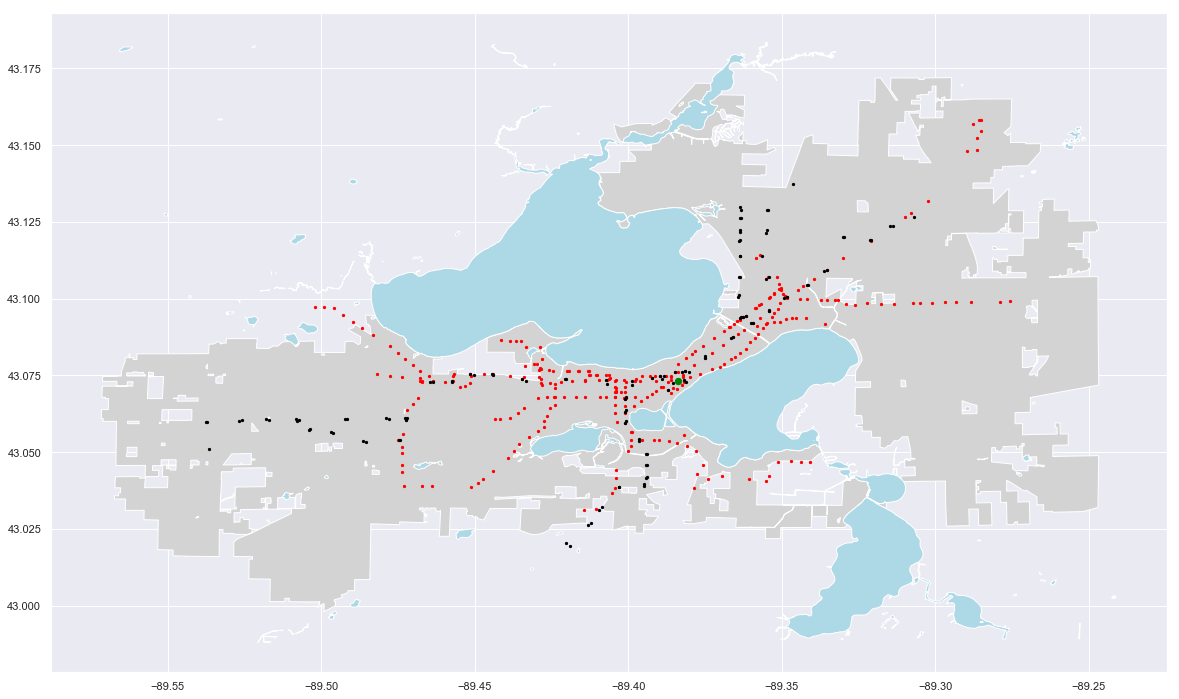

In [13]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)

stops_coord.plot(color="red", ax=ax, markersize= 5)
brt_coord.plot(color="black", ax=ax, markersize= 5)
first_stops_coord.plot(color="green", ax=ax, markersize= 40)

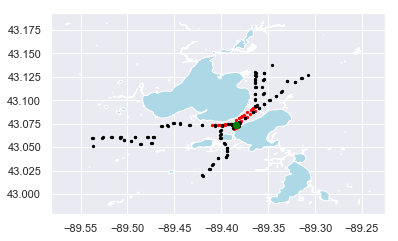

In [14]:
def draw_frame(ax, percent):
    ax.cla()
    h,f=stops_reachable_percent('1787_26047', 1*percent)
    list_of_stops = []
    for s in f:
        sls =s.split('_', 1)[0] 
        if sls not in list_of_stops:
            list_of_stops.append(sls)
            
    list_stops = []
    row = ''
    for stops in list_of_stops:
        row = stop_table[stop_table['stop_id'] == int(stops)]
        try:
            lat=row['stop_lat'].values[0]
            lon = row['stop_lon'].values[0]
        except:
            print(stops)
            print(row)
            break
        list_stops.append(Point(float(lon),float(lat)))

    stops_series = pd.Series(list_stops)
    stops_coord = pd.DataFrame({"Coordinates": stops_series})
    stops_coord = geopandas.GeoDataFrame(stops_coord, geometry='Coordinates')
    
    #ax = madison.plot(color="lightgray", figsize=(20,20))
    lakes.plot(color="lightblue", ax=ax)

    stops_coord.plot(color="red", ax=ax, markersize= 5)
    brt_coord.plot(color="black", ax=ax, markersize= 5)
    first_stops_coord.plot(color="green", ax=ax, markersize= 40)

    
    
    
fig, ax = plt.subplots()

draw_frame(ax, 0.2)    

In [15]:
%%capture
fig, ax = plt.subplots(figsize=(20,20))

In [16]:
from matplotlib import animation
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

SECONDS = 10
INTERVAL_MS = 200
TOTAL_FRAMES = int(SECONDS * 1000 / INTERVAL_MS)

def update(frame_num):
    draw_frame(ax, frame_num/TOTAL_FRAMES)
    
vid = animation.FuncAnimation(fig, update, frames=TOTAL_FRAMES, interval=INTERVAL_MS)
html = vid.to_html5_video()
HTML(html)

<Figure size 432x288 with 0 Axes>

In [ ]:
# you can save the video by right clicking the video